In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import gc
import fpfs
import fitsio
import numpy as np
from fpfs import pltutil
import matplotlib.pylab as plt
import numpy.lib.recfunctions as rfn

import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally

ver='try2'
gver='unif_cosmo170'
#gver='basic2Shift'
dver='cut32'
wrkDir=os.environ['homeWrk']
simDir=os.path.join(wrkDir,'FPFS2/sim/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# read noiseless data
nver='var0em0' 
mm1=[]
mm2=[]
for _i in range(0,100):
    _a1=fitsio.read(os.path.join(simDir,'srcfs3_%s-%s_%s/psf60/fpfs-%s-%04d-g1-0000.fits' %(gver,nver,ver,dver,_i)))
    _a2=fitsio.read(os.path.join(simDir,'srcfs3_%s-%s_%s/psf60/fpfs-%s-%04d-g1-2222.fits' %(gver,nver,ver,dver,_i)))
    mm1.append(_a1)
    mm2.append(_a2)
    del _a1,_a2#,msk1,msk2
mm1 =   rfn.stack_arrays(mm1,usemask=False)
mm2 =   rfn.stack_arrays(mm2,usemask=False)
gc.collect()

9389

In [25]:
gc.collect()
Const  =   22.
noirev =   False
ellM1  =   fpfs.catalog.fpfsM2E(mm1,const=Const,noirev=noirev)
ellM2  =   fpfs.catalog.fpfsM2E(mm2,const=Const,noirev=noirev)
gc.collect()

0

In [ ]:
pix_scale=0.168
nbins=70
m1   =   -2.5 * np.log10(mm1['fpfs_M00']) + 27.
r2   =   (mm1['fpfs_M20']+mm1['fpfs_M00'])/(mm1['fpfs_M00'])
msk=(m1<25.5)&(r2>=0.05)
plt.close()
fig,axes=pltutil.make_figure_axes(nx=1,ny=2,square=False)
ax=axes[0]
ax.hist(m1,bins=nbins,density=False,linewidth=2.,color=pltutil.colors[1],range=(20,27),label='All',alpha=0.8,histtype='stepfilled')
ax.hist(m1[msk],bins=nbins,density=False,linewidth=2.,color=pltutil.colors[2],range=(20,27),label='Selected',alpha=0.4,histtype='stepfilled')

leg=ax.legend(loc='upper left',fontsize=20,handlelength=0,handletextpad=0,fancybox=False,markerscale=0)
for it,text in enumerate(leg.get_texts()):
    text.set_color(pltutil.colors[it+1])
ax.set_xlim(21,27)
ax.set_yscale('log')
ax.set_xlabel('FPFS magnitude')
ax.set_ylabel('PDF')
ax.grid()

ax=axes[1]
ax.hist(r2,bins=nbins,density=False,linewidth=2.,color=pltutil.colors[1],range=(-0.3,2.8),alpha=0.8,histtype='stepfilled')
ax.hist(r2[msk],bins=nbins,density=False,linewidth=2.,color=pltutil.colors[2],range=(-0.3,2.8),alpha=0.4,histtype='stepfilled')
#ax.set_xlim(-0.3,0.8)
ax.set_yscale('log')
ax.set_xlabel('FPFS resolution')
ax.set_ylabel('PDF')
ax.grid()
fig.tight_layout()


gc.collect()
fig.savefig('obsHist.pdf')

In [ ]:
#del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['detect','R2','M00']
dcc=-0.6
cutB=27.
cutsig=[0.2,0.2,0.2]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,6):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    mcut=cutB+dcc*i
    cut=[0.06,0.06,10**((27-mcut)/2.5)]
    print(mcut,cut)
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(mcut)
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

27.0 [0.06, 0.06, 1.0]
26.4 [0.06, 0.06, 1.7378008287493778]
25.8 [0.06, 0.06, 3.0199517204020143]


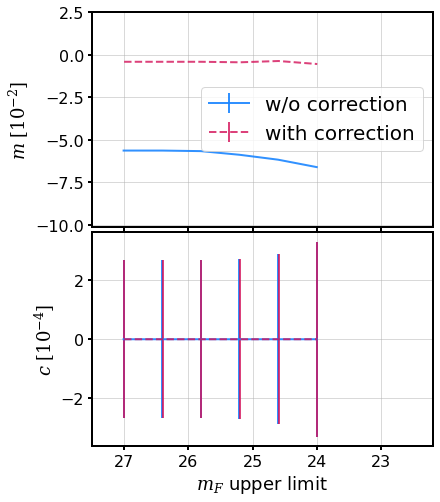

In [40]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$m_{F}$ upper limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.zeros(len(yerr))*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.zeros(len(yerr))*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(22.2,27.5)
ax.set_ylim(-10.1,2.5)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.invert_xaxis()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(22.2,27.5)
#ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()
ax.invert_xaxis()

plt.tight_layout(h_pad=-0.2)

In [48]:
#del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['detect','R2','M00']
dcc=0.06
cutB=0.0
cutsig=[0.2,0.2,0.2]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,4):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    rcut=cutB+i*dcc
    cut=[0.01,rcut,3.9]
    print(rcut,cut)
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(rcut)
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

0.0 [0.01, 0.0, 3.9]
0.06 [0.01, 0.06, 3.9]
0.12 [0.01, 0.12, 3.9]
0.18 [0.01, 0.18, 3.9]


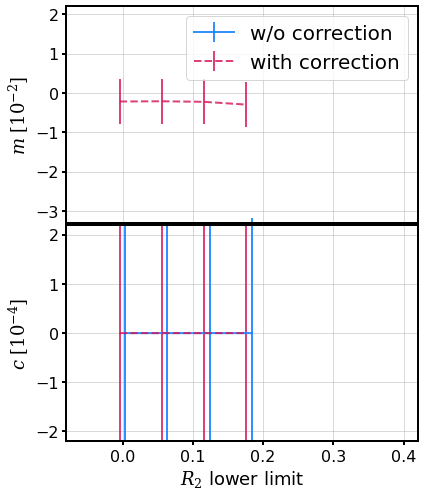

In [49]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$R_2$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-3.3,2.2)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

In [35]:
del fs1,fs2
gc.collect()
use_sig=False
fs1=fpfs.catalog.summary_stats(mm1,ellM1,use_sig)
fs2=fpfs.catalog.summary_stats(mm2,ellM2,use_sig)

selnm=['detect','R2','M00']
dcc=0.05
cutB=-0.02
cutsig=[0.2,0.2,0.5]

x=[]
y1=[];y2=[];yerr=[]
z1=[];z2=[];zerr=[]
for i in range(0,4):
    # clean outcome
    fs1.clear_outcomes()
    fs2.clear_outcomes()
    cut=cutB+dcc*i
    print(cut)
    cut=[cut,0.05,3.9]
    # weight array
    fs1.update_selection_weight(selnm,cut,cutsig);fs2.update_selection_weight(selnm,cut,cutsig)
    fs1.update_selection_bias(selnm,cut,cutsig);fs2.update_selection_bias(selnm,cut,cutsig)
    fs1.update_ellsum();fs2.update_ellsum()
    de   = fs2.sumE1-fs1.sumE1
    eA   = (fs1.sumE1+fs2.sumE1)/2.
    eAR  = (fs1.sumE1+fs2.sumE1+fs1.corE1+fs2.corE1)/2.
    rave = (fs1.sumR1+fs2.sumR1)/2.
    raveR= (fs1.sumR1+fs2.sumR1+fs1.corR1+fs2.corR1)/2.
    x.append(cut[0])
    y1.append(de/rave/0.04-1);y2.append(de/raveR/0.04-1)
    yerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR/0.04)
    z1.append(eA/rave);z2.append(eAR/rave)
    zerr.append(0.15*np.sqrt(np.sum((fs2.ell['fpfs_R1E']*fs2.ws)**2.))/raveR)

-0.02
0.030000000000000002
0.08
0.13000000000000003


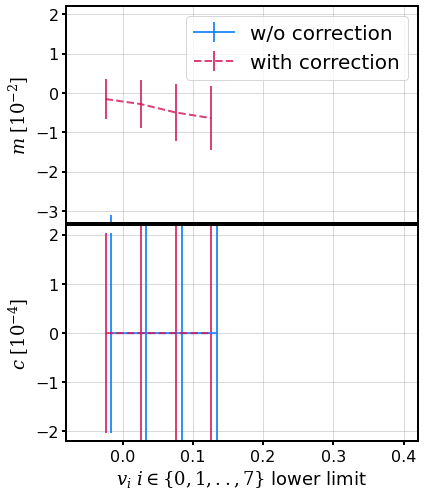

In [36]:
# make plot
plt.close()
fig,axes=pltutil.make_figure_axes(ny=2,nx=1,square=False)
ax=axes[0]
xlabel='$v_{i}~ i \in \{0,1,..,7\}$ lower limit';
ax.errorbar(np.array(x)+0.004,np.array(y1)*1e2,np.array(yerr)*1e2,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(y2)*1e2,np.array(yerr)*1e2,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$m$ $[10^{-2}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-3.3,2.2)
ax.tick_params(width=2,size=4)
ax.set_xticklabels([])
ax.grid()
ax.legend()
ax=axes[1]
ax.errorbar(np.array(x)+0.004,np.array(z1)*1e4,np.array(zerr)*1e4,label='w/o correction',color=pltutil.colors[1])
ax.errorbar(np.array(x)-0.004,np.array(z2)*1e4,np.array(zerr)*1e4,label='with correction',color=pltutil.colors[2],ls='--')
ax.set_ylabel('$c$ $[10^{-4}]$',fontsize=18)
ax.set_xlim(-0.08,0.42)
ax.set_ylim(-2.2,2.2)
ax.tick_params(width=2,size=4)
ax.set_xlabel(xlabel,fontsize=18)
#hist,bins=np.histogram(fs1.mm['fpfs_M00'],range=(-0.05,0.46),bins=100,density=True)
#cbin=(bins[1:]+bins[:-1])/2.
#sf=hist.max()/2.
#hist=hist/sf
#ax.fill_between(cbin,hist,color=pltutil.colors[-1],alpha=0.2)
ax.grid()

plt.tight_layout(h_pad=-0.2)

(array([ 8062., 16748., 22779., 27826., 29716., 33311., 35780., 35772.,
        36215., 39216., 38688., 40520., 45407., 48513., 47387., 51755.,
        54632., 50593., 55133., 53982., 52288., 52814., 48248., 47719.,
        50205., 46490., 48713., 49189., 47571., 49797., 48047., 45891.,
        45436., 46462., 42631., 47482., 44095., 46274., 42913., 42070.,
        38587., 38390., 32590., 32417., 28128., 28166., 21764., 17073.,
        14356.,  7424.]),
 array([ 240.  ,  331.18,  422.36,  513.54,  604.72,  695.9 ,  787.08,
         878.26,  969.44, 1060.62, 1151.8 , 1242.98, 1334.16, 1425.34,
        1516.52, 1607.7 , 1698.88, 1790.06, 1881.24, 1972.42, 2063.6 ,
        2154.78, 2245.96, 2337.14, 2428.32, 2519.5 , 2610.68, 2701.86,
        2793.04, 2884.22, 2975.4 , 3066.58, 3157.76, 3248.94, 3340.12,
        3431.3 , 3522.48, 3613.66, 3704.84, 3796.02, 3887.2 , 3978.38,
        4069.56, 4160.74, 4251.92, 4343.1 , 4434.28, 4525.46, 4616.64,
        4707.82, 4799.  ]),
 <BarContainer ob

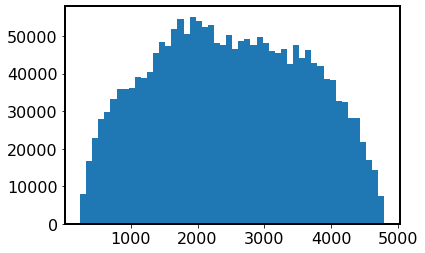

In [11]:
plt.hist(mm1['fpfs_x'],bins=50)

In [66]:
mm1['fpfs_x'].min()

247

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0., 15207.,
        58751., 69742., 79928., 87838., 94004., 96089., 95986., 92240.,
        87561., 83919., 78790., 70348., 61752., 52026., 41853., 33155.,
        26748., 21378., 17830., 15163., 12768., 10880.,  9644.,  8373.,
         7397.,  6758.,  5958.,  5455.,  5057.,  4594.,  4010.,  3714.,
         3588.,  3191.,  2968.,  2760.,  2606.,  2425.,  2330.,  2106.,
         2012.,  1927.]),
 array([-0.3  , -0.274, -0.248, -0.222, -0.196, -0.17 , -0.144, -0.118,
        -0.092, -0.066, -0.04 , -0.014,  0.012,  0.038,  0.064,  0.09 ,
         0.116,  0.142,  0.168,  0.194,  0.22 ,  0.246,  0.272,  0.298,
         0.324,  0.35 ,  0.376,  0.402,  0.428,  0.454,  0.48 ,  0.506,
         0.532,  0.558,  0.584,  0.61 ,  0.636,  0.662,  0.688,  0.714,
         0.74 ,  0.766,  0.792,  0.818,  0.844,  0.87 ,  0.896,  0.922,
         0.948,  0.974,  1.   ]),
 <BarContainer object of 50 artists>)

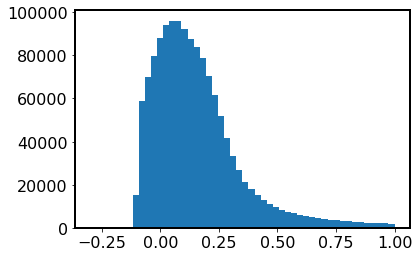

In [72]:
plt.hist(mm1['fpfs_v0'][msk],range=(-0.3,1),bins=50)

(array([    0.,     0.,     0.,     0.,  2454., 15169., 28543., 43587.,
        58059., 68892., 79155., 86735., 92505., 94546., 94636., 87499.,
        85434., 82229., 76464., 67898., 56774., 44703., 34341., 27187.,
        21775., 17905., 14760., 12812., 11016.,  9752.,  8289.,  7464.,
         6803.,  5994.,  5316.,  4979.,  4365.,  4037.,  3641.,  3524.,
         3244.,  2915.,  2683.,  2586.,  2454.,  2329.,  2080.,  1931.,
         1880.,  1777.]),
 array([-0.3  , -0.274, -0.248, -0.222, -0.196, -0.17 , -0.144, -0.118,
        -0.092, -0.066, -0.04 , -0.014,  0.012,  0.038,  0.064,  0.09 ,
         0.116,  0.142,  0.168,  0.194,  0.22 ,  0.246,  0.272,  0.298,
         0.324,  0.35 ,  0.376,  0.402,  0.428,  0.454,  0.48 ,  0.506,
         0.532,  0.558,  0.584,  0.61 ,  0.636,  0.662,  0.688,  0.714,
         0.74 ,  0.766,  0.792,  0.818,  0.844,  0.87 ,  0.896,  0.922,
         0.948,  0.974,  1.   ]),
 <BarContainer object of 50 artists>)

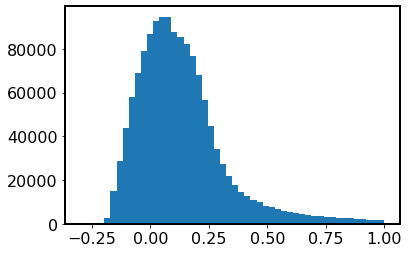

In [77]:
plt.hist(mm1['fpfs_v4'][msk],range=(-0.3,1),bins=50)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0., 15343.,
        58772., 70237., 80531., 87821., 93641., 96955., 98827., 90087.,
        87733., 85840., 81847., 75967., 64958., 51330., 39685., 30515.,
        24565., 20058., 16582., 14282., 12196., 10511.,  9233.,  8158.,
         7195.,  6275.,  5778.,  5269.,  4649.,  4333.,  4032.,  3680.,
         3405.,  3130.,  2914.,  2701.,  2525.,  2330.,  2174.,  2121.,
         1948.,  1854.]),
 array([-0.3  , -0.274, -0.248, -0.222, -0.196, -0.17 , -0.144, -0.118,
        -0.092, -0.066, -0.04 , -0.014,  0.012,  0.038,  0.064,  0.09 ,
         0.116,  0.142,  0.168,  0.194,  0.22 ,  0.246,  0.272,  0.298,
         0.324,  0.35 ,  0.376,  0.402,  0.428,  0.454,  0.48 ,  0.506,
         0.532,  0.558,  0.584,  0.61 ,  0.636,  0.662,  0.688,  0.714,
         0.74 ,  0.766,  0.792,  0.818,  0.844,  0.87 ,  0.896,  0.922,
         0.948,  0.974,  1.   ]),
 <BarContainer object of 50 artists>)

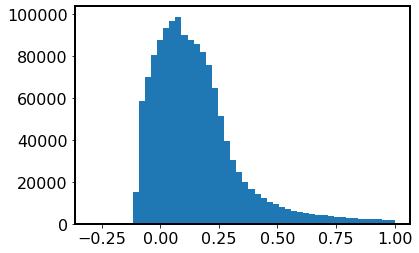

In [71]:
msk=(mm1['fpfs_v3']>-0.1)&(mm1['fpfs_v1']>-0.1)&(mm1['fpfs_v5']>-0.1)&(mm1['fpfs_v7']>-0.1)
msk=msk&(mm1['fpfs_v0']>-0.1)&(mm1['fpfs_v2']>-0.1)&(mm1['fpfs_v3']>-0.1)&(mm1['fpfs_v6']>-0.1)
plt.hist(mm1['fpfs_v1'][msk],range=(-0.3,1),bins=50)

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 544298., 580240., 439893., 341384., 277686.,
        222050., 178586., 151632., 128654., 107169.,  92533.,  77466.,
         66977.,  56767.,  50452.,  43131.,  40860.,  36507.,  32251.,
         28820.,  26637.,  23300.,  21924.,  20040.,  17117.,  16633.,
         14950.,  14045.,  13516.,  11594.,  10909.,  10768.,  10039.,
          9068.,   8836.,   8097.,   7472.,   7406.,   6943.,   6549.,
          6348.]),
 array([-0.1  ,  0.102,  0.304,  0.506,  0.708,  0.91 ,  1.112,  1.314,
         1.516,  1.718,  1.92 ,  2.122,  2.324,  2.526,  2.728,  2.93 ,
         3.132,  3.334,  3.536,  3.738,  3.94 ,  4.142,  4.344,  4.546,
         4.748,  4.95 ,  5.152,  5.354,  5.556,  5.758,  5.96 ,  6.162,
         6.364,  6.566,  6.768,  6.97 ,  7.172,  7.374,  7.576,  7.778,
         7.98 ,  8.182,  8.384,  8.586,  8.788,  8.99 ,  9.192,  9.394,
         9.596,  9.798, 10.   ]),
 <BarContainer obj

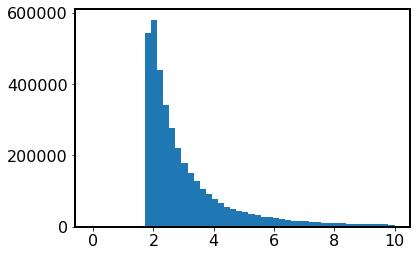

In [86]:
plt.hist(mm1['fpfs_M00'],range=(-0.1,10),bins=50)

(array([     0.,      0.,      0.,      0., 261073., 706851., 702990.,
        693884., 684809., 670192., 657312., 642684., 630317., 618491.,
        618949., 623183., 632767., 641123., 649438., 646569., 632327.,
        565168., 453571., 440218., 432579., 417951., 383091., 326911.,
        263215., 207811., 165072., 133261., 108703.,  90336.,  76528.,
         65056.,  56146.,  49221.,  43351.,  37702.,  34127.,  30641.,
         27594.,  25228.,  23322.,  20973.,  19281.,  17429.,  16346.,
         14919.]),
 array([-0.3  , -0.278, -0.256, -0.234, -0.212, -0.19 , -0.168, -0.146,
        -0.124, -0.102, -0.08 , -0.058, -0.036, -0.014,  0.008,  0.03 ,
         0.052,  0.074,  0.096,  0.118,  0.14 ,  0.162,  0.184,  0.206,
         0.228,  0.25 ,  0.272,  0.294,  0.316,  0.338,  0.36 ,  0.382,
         0.404,  0.426,  0.448,  0.47 ,  0.492,  0.514,  0.536,  0.558,
         0.58 ,  0.602,  0.624,  0.646,  0.668,  0.69 ,  0.712,  0.734,
         0.756,  0.778,  0.8  ]),
 <BarContainer obj

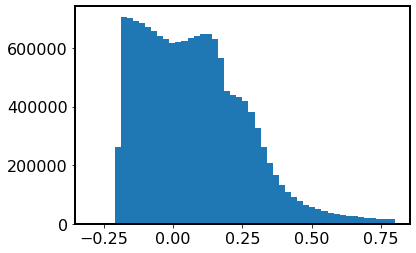

In [45]:
plt.hist(mm1['fpfs_v0'],range=(-0.3,0.8),bins=50)